# Import libraries

In [1]:
import os,glob
import math
import numpy as np
import pandas as pd
import scipy.io
import pickle
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,precision_score
from sklearn.metrics import mean_squared_error as performance_metric
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils

import matplotlib.pyplot as plt


# Generate XOR2 data
\begin{align*}
    y(x,z) \hspace{0.2cm}  &=
    \begin{cases}
        ReLU(0.5{x}_1 + {x}_2),& \text{if } z = 0,\\ 
       ReLU({x}_1 + 0.5{x}_2) ,& \text{if } z = 1,\\
        ReLU(0.5{x}_3 + {x}_4) ,& \text{if } z = 2,\\
        ReLU({x}_3 + 0.5{x}_4) ,& \text{if } z = 3.\\
    \end{cases} . 
\end{align*}

In [2]:


def relu(x):
    return np.maximum(0, x)


def get_raw_data(n_samples,data="train",cv_cur=0,dim_x=30):
    # Set random seed for reproducibility
    if data=="train":
        np.random.seed(0+10*cv_cur)
    elif data=="val":
        np.random.seed(1+10*cv_cur)
    elif data=="test":
        np.random.seed(2+10*cv_cur)

    # Number of samples
    # n_samples = 1000

    # Dimension of X
    dim_x = dim_x

    # Generate X
    X = np.random.randn(n_samples, dim_x)  # This also covers x4, x5, and x6 as they are Gaussian random noise

    # Initialize Y
    Y = np.zeros((n_samples, 1))

    # Generate Z
    Z = np.random.randint(0, 4, (n_samples, 1))

    # Compute Y according to Z and the rules
    for i in range(n_samples):
        if Z[i, 0] == 0:
            Y[i, 0] = relu(0.5*X[i, 0] + X[i, 1])
        elif Z[i, 0] == 1:
            Y[i, 0] = relu(X[i, 0] + 0.5*X[i, 1])
        elif Z[i, 0] == 2:
            Y[i, 0] = relu(0.5*X[i, 2] + X[i, 3])
        elif Z[i, 0] == 3:
            Y[i, 0] = relu(X[i, 2] + 0.5*X[i, 3])

    # Now, X, Y, and Z are NumPy arrays containing the data.
    # X: Input features
    # Y: Outputs
    # Z: Determines the relationship between X and Y
    return X,np.eye(4)[Z.flatten()],Y

def get_data(cv_cur,dim_x=30):
    
    X_train,T_train,y_train = get_raw_data(1000,data="train",cv_cur=cv_cur,dim_x=dim_x)
    X_val,T_val,y_val = get_raw_data(1000,data="val",cv_cur=cv_cur,dim_x=dim_x)
    X_test,T_test,y_test = get_raw_data(1000,data="test",cv_cur=cv_cur,dim_x=dim_x)
    
#     X_train,y_train,T_train,X_val,y_val,T_val,X_test,y_test,T_test = get_raw_data(seed=cv_cur)
    
    input_dim,param_dim,output_dim = X_train.shape[-1],T_train.shape[-1],1
    
    trainset = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(y_train[:,None]),torch.tensor(T_train))
    valset = data_utils.TensorDataset(torch.tensor(X_val), torch.tensor(y_val[:,None]),torch.tensor(T_val))
    testset = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(y_test[:,None]),torch.tensor(T_test))
    
    train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True,drop_last=False)
    val_dataloader = torch.utils.data.DataLoader(valset, batch_size=10000, shuffle=True,drop_last=False)
    test_dataloader = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=True,drop_last=False)
    return train_dataloader,val_dataloader,test_dataloader,input_dim,param_dim,output_dim


# test_cur = 0
# val_cur = 0
train_dataloader,val_dataloader,test_dataloader,x_dim,z_dim,y_dim = get_data(0,dim_x=30)




# Define model 

In [3]:
class FeatureSelector(nn.Module):
    def __init__(self, hyper_input_dim,hyper_output_dim,hyper_hidden_dim, sigma=0.5,non_param_stg=False,train_sigma=False, is_cen=False):
        super(FeatureSelector, self).__init__()
        # hyper_input_dim: input dimension for the hyper network i.e dimensionality of contextual input
        # hyper_output_dim: output dimension for the hyper network i.e dimensionality of explanatory features
        # hyper_hidden_dim: dimensionals of hidden layers in the hyper network
        self.non_param_stg = non_param_stg
        self.hyper_output_dim = hyper_output_dim
        self.train_sigma = train_sigma
        self.is_cen = is_cen

        # Define hyper network 
        if self.non_param_stg:
            self.mu = torch.nn.Parameter(0.01*torch.randn(self.hyper_output_dim, )+0.5, requires_grad=True)
        else:
            self.hyper_dense_layers = nn.ModuleList()
            if len(hyper_hidden_dim):
                self.hyper_dense_layers.append(nn.Linear(hyper_input_dim, hyper_hidden_dim[0]))
                self.hyper_dense_layers.append(nn.ReLU())
                for i in range(len(hyper_hidden_dim)-1):
                    self.hyper_dense_layers.append(nn.Linear(hyper_hidden_dim[i], hyper_hidden_dim[i+1]))
                    self.hyper_dense_layers.append(nn.ReLU())
                self.hyper_dense_layers.append(nn.Linear(hyper_hidden_dim[-1], hyper_output_dim))
                self.hyper_last_weight_layer = nn.Linear(hyper_hidden_dim[-1], hyper_output_dim)
            else:
                self.hyper_dense_layers.append(nn.Linear(hyper_input_dim, hyper_output_dim))
                self.hyper_last_weight_layer = nn.Linear(hyper_input_dim, hyper_output_dim)
            self.hyper_dense_layers.append(nn.Sigmoid())
        
        self.noise = torch.randn(hyper_output_dim,) 
        self.sigma = nn.Parameter(torch.tensor([sigma]), requires_grad=train_sigma)

    def forward(self, prev_x, B, axis=2):
        # compute the feature importance given B
        stochastic_gate, weights = self.get_feature_importance(B)
        
        # mask the input with feature importance
        if self.non_param_stg:
            new_x = prev_x * stochastic_gate[None,:]
        else:
            new_x = prev_x * stochastic_gate[:,:]
            new_x = new_x * weights
        return new_x
    
    def get_feature_importance(self,B=None):
        # compute feature importance given contextual input (B)
        if not self.non_param_stg:
            self.mu = B
            self.weights = B
            for layer_idx,dense in enumerate(self.hyper_dense_layers):
                self.mu = dense(self.mu)
                if layer_idx<=len(self.hyper_dense_layers)-3:
                    self.weights = dense(self.weights)
                elif layer_idx==len(self.hyper_dense_layers)-2:
                    self.weights = self.hyper_last_weight_layer(self.weights)
                    
        if self.train_sigma:
            self.sigma = nn.ReLU(self.sigma)+0.01
            
        if self.is_cen:
            stochastic_gate = self.mu
            self.weights = None
        else:
            z = self.mu + (self.sigma)*self.noise.normal_()*self.training 
            stochastic_gate = self.hard_sigmoid(z)

        return stochastic_gate,self.weights
        
    
    def hard_sigmoid(self, x):
        return torch.clamp(x, 0.0, 1.0)

    def regularizer(self, x):
        ''' Gaussian CDF. '''
        return 0.5 * (1 + torch.erf(x / self.sigma*math.sqrt(2))) 

    def _apply(self, fn):
        super(FeatureSelector, self)._apply(fn)
        self.noise = fn(self.noise)
        return self


class LinearModel(nn.Module):
    def __init__(self, x_dim, z_dim, y_dim,hyper_hidden_dim):
        super(LinearModel, self).__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.y_dim = y_dim
        
        self.gates = FeatureSelector(z_dim, x_dim, hyper_hidden_dim)
        self.reg = self.gates.regularizer 
        
    def forward(self, x, z):
        x = self.gates(x, z)
        out = torch.sum(x , dim=1)
        out = nn.ReLU()(out)
        return out


# Load trained models and Compute test r2_score and sparsity

In [4]:
ML_model_name = "cSTG_param_prediction_model"

epochs = 500
dropout = 0

dim_x = 25
learning_rate = 0.01
stg_regularizer = 0.01
rand_init_seed = 0
input_dim = 25
param_dim = 4
output_dim = 1

gpu = torch.device('cpu')

hyper_hidden_dim = []
hidden_dims = []


train_metric_rand_init = {}
val_metric_rand_init = {}
test_metric_rand_init = {}
sparsity_rand_init = {}
clf_stats = []

dim_x = 25
learning_rate = 0.01
stg_regularizer = 0.01
rand_init_seed = 0
stg = True 
train_metric_rand_init[rand_init_seed] = []   
val_metric_rand_init[rand_init_seed] = []
test_metric_rand_init[rand_init_seed] = []
sparsity_rand_init[rand_init_seed] = []


for val_cur in range(5):


    add_foldername = ""


    root_fname = "./Trained_Models/XOR2"
          
    if not os.path.exists(root_fname):
        os.mkdir(root_fname)
        
    train_dataloader,val_dataloader,test_dataloader,input_dim,param_dim,output_dim = get_data(val_cur,dim_x=dim_x)
    x_dim,z_dim,y_dim = input_dim,param_dim,output_dim

    torch.manual_seed(rand_init_seed)
    np.random.seed(rand_init_seed)

    add_name = ""
    add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))

    add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))

    model_path = "{}/{}_lr_{}_stg_lr_{}{}_init_{}_val_seed_{}_stg_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,val_cur,rand_init_seed,stg)
    loss_path = model_path.replace("model","mat")
    
    model = LinearModel(x_dim, z_dim, y_dim, hyper_hidden_dim)
    model = model.to(gpu).float()

    model.load_state_dict(torch.load(model_path, map_location=gpu))
    model.eval()

    mat_content = scipy.io.loadmat(loss_path)
    val_metric_array = np.squeeze(mat_content['val_metric'], axis=0).tolist()[1:]
    test_metric_array = np.squeeze(mat_content['test_metric'], axis=0).tolist()[1:]

    val_metric = val_metric_array[np.argmax(val_metric_array)]
    test_metric = test_metric_array[np.argmax(val_metric_array)]

    val_metric_rand_init[rand_init_seed].append(val_metric)
    test_metric_rand_init[rand_init_seed].append(test_metric)

    sparsity = 0
    count = 0
    for batch, (input, target, B) in enumerate(test_dataloader):
        input = input.to(gpu).float()
        target = target.to(gpu).float()
        B = B.to(gpu).float()
        mu,w = model.gates.get_feature_importance(B)
        mu = mu.detach().cpu().numpy()
        w = w.detach().cpu().numpy()

        sparsity += np.sum(np.sum(((mu>0.6)*w)!=0,axis=1))
        count += mu.shape[0]
    sparsity = sparsity/count

    sparsity_rand_init[rand_init_seed].append(sparsity)


val_metric_mean = np.round(np.mean(val_metric_rand_init[rand_init_seed]),4)
test_metric_mean = np.round(np.mean(test_metric_rand_init[rand_init_seed]),4)
val_metric_std = np.round(np.std(val_metric_rand_init[rand_init_seed]),4)
test_metric_std = np.round(np.std(test_metric_rand_init[rand_init_seed]),4)

sparsity_mean = np.round(np.mean(sparsity_rand_init[rand_init_seed]),4)
sparsity_std = np.round(np.std(sparsity_rand_init[rand_init_seed]),4)

print("Test Accuracy: {:.4f} ({:.4f})".format(test_metric_mean,test_metric_std))
print("Sparsity: {:.2f} ({:.2f})".format(sparsity_mean,sparsity_mean))



Test Accuracy: 0.9956 (0.0008)
Sparsity: 2.00 (2.00)


# Plot feature significance

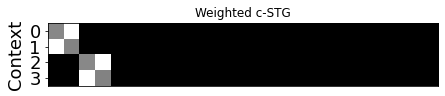

In [5]:
dim_x = 25
learning_rate = 0.01
stg_regularizer = 0.01
rand_init_seed = 0

val_cur = 0

train_dataloader,val_dataloader,test_dataloader,input_dim,param_dim,output_dim = get_data(val_cur,dim_x=dim_x)
x_dim,z_dim,y_dim = input_dim,param_dim,output_dim

torch.manual_seed(rand_init_seed)
np.random.seed(rand_init_seed)

add_foldername = ""

root_fname = "./Trained_Models/XOR2"
if not os.path.exists(root_fname):
    os.mkdir(root_fname)

add_name = ""
add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))

add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))

model_path = "{}/{}_lr_{}_stg_lr_{}{}_init_{}_val_seed_{}_stg_{}.model".format(root_fname,ML_model_name,str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name,val_cur,rand_init_seed,stg)
loss_path = model_path.replace("model","mat")

model = LinearModel(x_dim, z_dim, y_dim, hyper_hidden_dim)
model = model.to(gpu).float()

model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()


model.eval()
z = torch.tensor(np.eye(4)).to(gpu).to(B.dtype)
mu,w = model.gates.get_feature_importance(z)
mu = mu.detach().cpu().numpy()
w = w.detach().cpu().numpy()

mu = mu>0.5

w_cSTG_feature_significance = w*mu
plt.figure(figsize=(7,5))
plt.imshow(w_cSTG_feature_significance,vmin=0,vmax=1,cmap='gray')
plt.yticks([0,1,2,3],fontsize=18)
plt.ylabel("Context",fontsize=18)
plt.xticks([])
plt.title("Weighted c-STG")
plt.show()